# ITCS 4152/5152 Assignment2-Part2
**Due date: 11:59 pm EST on Oct 31, 2022 (Mon.)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features


This is an approach that represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do).

There are 2 sub problems (under Problem 1) in this homework with a total of 60 points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [1]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Replace '------' with the path such that "ITCS_4152_5152_assignment2" is your working directory
%cd '/content/gdrive/My Drive/CV/Katiyar_Nalini_801204572_assignment2_part2'

/content/gdrive/My Drive/CV/Katiyar_Nalini_801204572_assignment2_part2


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [22]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    if augment: 
        for i in range(len(data)):
          flip_img = cv2.flip(data[i], 1)
          data.append(flip_img)
          labels.append(labels[i])


    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        mean = np.mean(data, axis=0)
        for index in range(len(data)):
          data[index]-= mean

        
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Street', 1: 'Suburb', 2: 'TallBuilding', 3: 'Bedroom', 4: 'Coast', 5: 'Highway', 6: 'LivingRoom', 7: 'Mountain', 8: 'Kitchen', 9: 'Industrial', 10: 'Forest', 11: 'InsideCity', 12: 'Flower', 13: 'Office', 14: 'OpenCountry', 15: 'Store'} 


In [16]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

Store


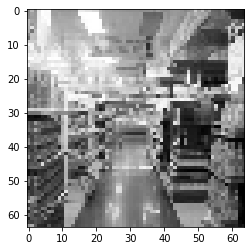

In [6]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [7]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  

Then, let's define model training and evaluation functions.

In [8]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [9]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [10]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:11 | Train Loss: 2.7894 | Average Loss: 2.7894 
Epoch: 1 | Iter:   20 | Time: 00:00:11 | Train Loss: 2.4408 | Average Loss: 2.6586 
Accuracy: 0.343750 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.8163 | Average Loss: 2.4479 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.8247 | Average Loss: 2.2412 
Accuracy: 0.427083 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.4815 | Average Loss: 2.1158 
Epoch: 3 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.4239 | Average Loss: 1.9789 
Accuracy: 0.473958 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.2402 | Average Loss: 1.8819 
Epoch: 4 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.1214 | Average Loss: 1.7754 
Accuracy: 0.505208 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.0428 | Average Loss: 1.6944 
Epoch: 5 | Iter:   20 | Time: 00:00:11 | Train Loss: 0.8995 | Average Loss: 1.6066 
Accuracy: 0.5208

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(30 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [17]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
(64, 64)
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
(64, 64)
Fini

In [18]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  

In [21]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7641 | Average Loss: 2.7641 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.4888 | Average Loss: 2.7091 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.0288 | Average Loss: 2.4756 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.8127 | Average Loss: 2.3128 
Accuracy: 0.414062 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.3418 | Average Loss: 2.2063 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.5881 | Average Loss: 2.0844 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.5436 | Average Loss: 1.9887 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.3992 | Average Loss: 1.9061 
Accuracy: 0.484375 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.0843 | Average Loss: 1.8475 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.2926 | Average Loss: 1.7780 
Epoch: 3 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.2325 | Average Loss: 1.7168 
Epoc

**Answer**:

(1) which layers of AlexNet have been replaced



(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation: 

Data normalization: 

Features Layers : 

Classifier Layer 1: 

Classifier Layer 2: 

Classifier Layer 3: 

...

(3) the final accuracy on test set

Accuracy on test set: 



## Problem 1.2

(30 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

### Technique 1

In [23]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [71]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features1 = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.MaxPool2d(4, stride=4), 
      )
      self.features2 = torch.nn.Sequential(
        nn.Conv2d(32, 16, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(4, stride=4), 
        
      )
      self.classifier = nn.Sequential(
         nn.Linear(3*3*16, 16), 
      )
      
    def forward(self, x):
      # print(x.shape)
      x = self.features1(x) 
      # print(x.shape)
      x = self.features2(x) 
      # print(x.shape)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
   

In [72]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002 #change
train_option['epoch'] = 30  #change
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8790 | Average Loss: 2.8790 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7771 | Average Loss: 2.7909 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.7852 | Average Loss: 2.7817 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.7749 | Average Loss: 2.7796 
Accuracy: 0.065104 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7706 | Average Loss: 2.7780 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7553 | Average Loss: 2.7760 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.7204 | Average Loss: 2.7716 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.7316 | Average Loss: 2.7669 
Accuracy: 0.088542 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.6715 | Average Loss: 2.7611 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6646 | Average Loss: 2.7538 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.6518 | Average Loss: 2.7427 
Epoc

**Answer**:

Technique 1: 

Accuracy on test set: 

Accuracy increases/decreases:

### Technique 2


In [74]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [89]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features1 = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.LeakyReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d(4, stride=4), 
      )
      self.features2 = torch.nn.Sequential(
        nn.Conv2d(32, 16, 3),
        nn.LeakyReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d(4, stride=4), 
        
      )
      self.classifier = nn.Sequential(
         nn.Linear(3*3*16, 16), 
      )
      
    def forward(self, x):
      print(x.shape)
      x = self.features1(x) 
      print(x.shape)
      x = self.features2(x) 
      print(x.shape)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
   


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.003 #change
train_option['epoch'] = 30  #change
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.9472 | Average Loss: 2.9472 
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16, 3, 3])
torch.Size([64, 1, 64, 64])
torch.Size([64, 32, 15, 15])
torch.Size([64, 16,

**Answer**:

Technique 2: 

Accuracy on test set: 

Accuracy increases/decreases:

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

In [112]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features1 = torch.nn.Sequential(
        nn.Conv2d(1, 32, 3, padding = 5),
        nn.LeakyReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d(4, stride=4), 
      )
      self.features2 = torch.nn.Sequential(
        nn.Conv2d(32, 16, 3, padding = 5),
        nn.LeakyReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d(4, stride=4), 
        
      )
      self.classifier = nn.Sequential(
         nn.Linear(6*6*16, 16), 
      )
      
    def forward(self, x):
      # print(x.shape)
      x = self.features1(x) 
      # print(x.shape)
      x = self.features2(x) 
      # print(x.shape)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
   


In [113]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.004 #change
train_option['epoch'] = 30  #change
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7621 | Average Loss: 2.7621 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5874 | Average Loss: 2.6974 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.4192 | Average Loss: 2.5662 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.1768 | Average Loss: 2.4655 
Accuracy: 0.309896 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.9725 | Average Loss: 2.3701 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.7136 | Average Loss: 2.2719 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.7586 | Average Loss: 2.1700 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 1.8251 | Average Loss: 2.0929 
Accuracy: 0.520833 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.3537 | Average Loss: 2.0274 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.4073 | Average Loss: 1.9627 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.5460 | Average Loss: 1.9009 
Epoc

**Answer**:

Technique 3: 

Accuracy on test set: 

Accuracy increases/decreases:

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_assignment2_part2' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on canvas due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_assignment2_part1.zip**.

This zip file should include:
```
Surname_Givenname_UNCCID_assignment2_part2  
        |---Surname_Givenname_UNCCID_assignment2_part2.ipynb
        |---Surname_Givenname_UNCCID_assignment2_part2.pdf
```

For instance, student Yann Lecun should submit a zip file named "Lecun_Yann_111134567_assignment2_part1.zip" for assignment2_part1 in this structure:
```
Lecun_Yann_111134567_assignment2_part2
        |---Lecun_Yann_111134567_assignment2_part2.ipynb
        |---Lecun_Yann_111134567_assignment2_part2.pdf
```

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: ***psingire@uncc.edu*** and ***kchiguru@uncc.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in canvas. 

Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_UNCCID_assignment1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
